In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [22]:
from torchsummary import summary
import torch
import torch.nn as nn
import torch.nn.functional as F


In [23]:

plt.rcParams.update({'font.size': 14})

model_args = {}
# we will use batch size of 64 in Stochastic Gradient Descent (SGD) optimization of the network
model_args['batch_size'] = 64 
# learning rate is how fast it will descend
model_args['lr'] = .05
# SGD momentum (default: .5) momentum is a moving average of gradients (it helps to keep direction) 
model_args['momentum'] = .9
# the number of epochs is the number of times you go through the full dataset
model_args['weight_decay'] = 5.e-4
model_args['epochs'] = 60

In [24]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

In [25]:
class SimpleCNN(nn.Module):
    '''
    simple CNN model
    '''
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 80)
        self.fc3 = nn.Linear(80, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class VGG(nn.Module):
    '''
    VGG model 
    '''
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 10),
        )
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
                m.bias.data.zero_()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

vgg_cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    'vgg22': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 256, 'M', 512, 512, 512, 512, 512, 'M', 512, 512, 512, 512, 512, 'M']
}

VGG means Visual Geometry Group

deep CNN with small kernel sizes (3x3)

number - number of convolutional layers

ResNet - residual neural network

skipping layers to avoid vanishing gradients and degradation

In [26]:
nns = ["SimpleCNN", "VGG11","VGG11_v2","VGG16","VGG19","VGG22"]
n_colors = len(nns)
colours = cm.rainbow(np.linspace(0, 1, n_colors))

In [27]:
normal = {}
for nn in nns:
    normal[nn] = np.loadtxt(nn+".txt")

In [28]:
unnormalized = {}
for nn in nns:
    unnormalized[nn] = np.loadtxt(nn+"_unnormalized.txt")

# 1. Check turning off the data normalization -- how this impacts network training. 
# + 
# 2.What happens if we put weight_decay = 0. and increase momentum to .9 for VGG11 model -- why is that? (hint: observe interplay between learning rate and momentum)

C:\Users\Olek\AppData\Local\Temp\ipykernel_16032\843739985.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


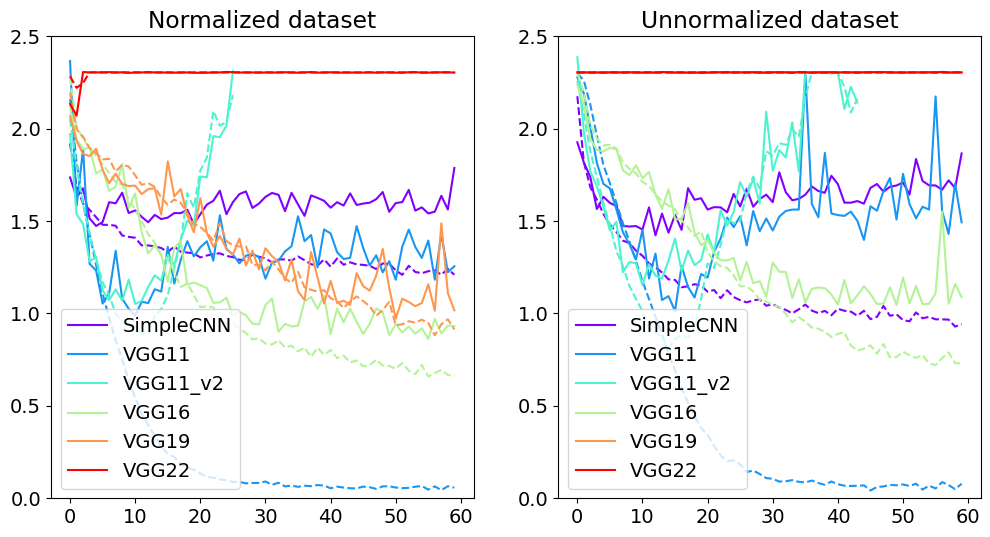

In [29]:
fig = plt.subplots(figsize=(12,6))
plt.subplot(121)
i=0
plt.title("Normalized dataset")
for model,loss in normal.items():
    plt.plot(loss[0,:],linestyle='--',color=colours[i])
    plt.plot(loss[1,:],color=colours[i],label=model)
    i+=1
plt.legend()
plt.ylim([0, 2.5])
plt.subplot(122)
i=0
plt.title("Unnormalized dataset")
for model,loss in unnormalized.items():
    plt.plot(loss[0,:],linestyle='--',color=colours[i])
    plt.plot(loss[1,:],color=colours[i],label=model)
    i+=1
plt.legend()
plt.ylim([0, 2.5])

plt.show()

On unnormalized dataset the model starts to  show overfitting faster

VGG11 : *weight_decay* = 1.e-3, *momentum*=0.5

VGG11_v2 : *weight_decay* = 0., *momentum*=0.9

# 3. Try to explain why the deeper VGG16 network trains longer than VGG11.

- VGG 16 has almost twice the number of parameters of VGG11

```python
VGG11
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]          73,856
              ReLU-5          [-1, 128, 16, 16]               0
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 8, 8]         295,168
              ReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         590,080
             ReLU-10            [-1, 256, 8, 8]               0
        MaxPool2d-11            [-1, 256, 4, 4]               0
           Conv2d-12            [-1, 512, 4, 4]       1,180,160
             ReLU-13            [-1, 512, 4, 4]               0
           Conv2d-14            [-1, 512, 4, 4]       2,359,808
             ReLU-15            [-1, 512, 4, 4]               0
        MaxPool2d-16            [-1, 512, 2, 2]               0
           Conv2d-17            [-1, 512, 2, 2]       2,359,808
             ReLU-18            [-1, 512, 2, 2]               0
           Conv2d-19            [-1, 512, 2, 2]       2,359,808
             ReLU-20            [-1, 512, 2, 2]               0
        MaxPool2d-21            [-1, 512, 1, 1]               0
          Dropout-22                  [-1, 512]               0
           Linear-23                  [-1, 512]         262,656
             ReLU-24                  [-1, 512]               0
          Dropout-25                  [-1, 512]               0
           Linear-26                  [-1, 512]         262,656
             ReLU-27                  [-1, 512]               0
           Linear-28                   [-1, 10]           5,130
================================================================
Total params: 9,750,922
Trainable params: 9,750,922
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 2.57
Params size (MB): 37.20
Estimated Total Size (MB): 39.78
----------------------------------------------------------------
```

```python
VGG16
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 256, 8, 8]               0
           Conv2d-15            [-1, 256, 8, 8]         590,080
             ReLU-16            [-1, 256, 8, 8]               0
        MaxPool2d-17            [-1, 256, 4, 4]               0
           Conv2d-18            [-1, 512, 4, 4]       1,180,160
             ReLU-19            [-1, 512, 4, 4]               0
           Conv2d-20            [-1, 512, 4, 4]       2,359,808
             ReLU-21            [-1, 512, 4, 4]               0
           Conv2d-22            [-1, 512, 4, 4]       2,359,808
             ReLU-23            [-1, 512, 4, 4]               0
        MaxPool2d-24            [-1, 512, 2, 2]               0
           Conv2d-25            [-1, 512, 2, 2]       2,359,808
             ReLU-26            [-1, 512, 2, 2]               0
           Conv2d-27            [-1, 512, 2, 2]       2,359,808
             ReLU-28            [-1, 512, 2, 2]               0
           Conv2d-29            [-1, 512, 2, 2]       2,359,808
             ReLU-30            [-1, 512, 2, 2]               0
        MaxPool2d-31            [-1, 512, 1, 1]               0
          Dropout-32                  [-1, 512]               0
           Linear-33                  [-1, 512]         262,656
             ReLU-34                  [-1, 512]               0
          Dropout-35                  [-1, 512]               0
           Linear-36                  [-1, 512]         262,656
             ReLU-37                  [-1, 512]               0
           Linear-38                   [-1, 10]           5,130
================================================================
Total params: 15,245,130
Trainable params: 15,245,130
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 4.48
Params size (MB): 58.16
Estimated Total Size (MB): 62.65
----------------------------------------------------------------
```

# 4. Compare with performance for deeper VGGs: 19 or 22 -- do we observe saturation in accuracy or even degradation problem?

The comparison:

VGG19 : 19 layers, ~20M parameters

ResNet18: 18 layers, ~11M parameters

ResNet34: 34 layers, ~21M parameters

In [30]:
rn18 = np.loadtxt("ResNet18.txt")
rn18_tr = np.loadtxt("ResNet18_tranfser.txt")
rn34 = np.loadtxt("ResNet34.txt")
vgg19 = normal['VGG19']

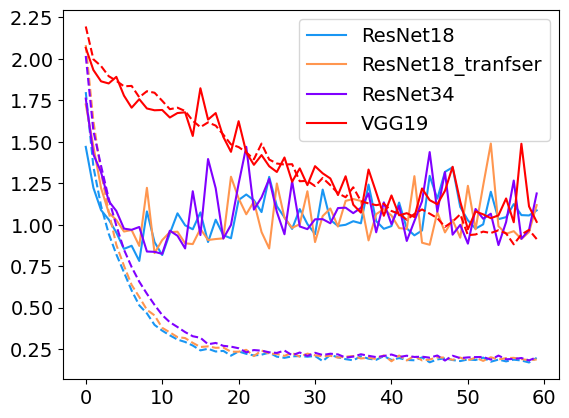

In [31]:
plt.plot(rn18[0,:],linestyle='--',color=colours[1])
plt.plot(rn18[1,:],color=colours[1],label="ResNet18")
plt.plot(rn18_tr[0,:],linestyle='--',color=colours[4])
plt.plot(rn18_tr[1,:],color=colours[4],label="ResNet18_tranfser")
plt.plot(rn34[0,:],linestyle='--',color=colours[0])
plt.plot(rn34[1,:],color=colours[0],label="ResNet34")

plt.plot(vgg19[0,:],linestyle='--',color=colours[5])
plt.plot(vgg19[1,:],color=colours[5],label="VGG19")
plt.legend()

# 6. Does transfer learning speed up training?

in this case ResNet18 cell evaluated for 21 mins and pretrained Resnet18 for 20 mins